# Meteorite Landings Data Analysis

## Overview
This notebook analyzes the Meteorite Landings dataset, which contains information about meteorite landings on Earth including data exploration, cleaning, preprocessing, and visualization to understand patterns in meteorite characteristics, landing locations, and temporal distributions.

## Dataset Source
The dataset is sourced from: https://catalog.data.gov/dataset/meteorite-landings

Dataset contains the following variables:

* `name` – The official name of the meteorite.
* `id` – A unique identifier for each meteorite.
* `nametype` – Indicates whether the meteorite is:
    - Valid: Most meteorites
    - Relict: Highly weathered meteorites
* `recclass` – The classification of the meteorite based on its composition and structure.
* `mass (g)` – The recorded mass of the meteorite in grams (if available).
* `fall` – Specifies whether the meteorite:
    - Fell: Observed falling and later recovered
    - Found: Discovered without being observed falling
* `year` – The year the meteorite was observed or discovered.
* `reclat` – The latitude of the meteorite's location.
* `reclong` – The longitude of the meteorite's location.
* `GeoLocation` – A structured representation of the meteorite’s geographic location in (latitude, longitude) format.

## 1. Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

In [2]:
# source: https://www.kaggle.com/datasets/nafayunnoor/meteorite-landings-on-earth-data

df = pd.read_csv('./data/Meteorite_Landings.csv')
df.head()

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation,Unnamed: 10
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)",NaN
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)",NaN
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)",NaN
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)",NaN
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)",NaN


## 2. Data Loading and Initial Exploration

In [3]:
# obtaining data types, non-null values and summary of the dataframe
print(df.info())

print('\n Summary Statistics:')
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45716 entries, 0 to 45715
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         45716 non-null  object 
 1   id           45716 non-null  int64  
 2   nametype     45716 non-null  object 
 3   recclass     45716 non-null  object 
 4   mass (g)     45585 non-null  float64
 5   fall         45716 non-null  object 
 6   year         45425 non-null  float64
 7   reclat       38401 non-null  float64
 8   reclong      38401 non-null  float64
 9   GeoLocation  38401 non-null  object 
 10  Unnamed: 10  0 non-null      float64
dtypes: float64(5), int64(1), object(5)
memory usage: 3.8+ MB
None

 Summary Statistics:
                 id      mass (g)          year        reclat       reclong  \
count  45716.000000  4.558500e+04  45425.000000  38401.000000  38401.000000   
mean   26889.735104  1.327808e+04   1991.828817    -39.122580     61.074319   
std    16860.683030

In [4]:
# obtaining the dimensions of the dataframe
shape = df.shape

print(f"number of rows = {shape[0]}")
print(f"number of columns = {shape[1]}")
print(f"number of duplicated rows = {df.duplicated().sum()}\n")

# Calculate null counts and percentages
null_values = df.isnull().sum()
null_percentage = (null_values / len(df)) * 100

# Combine into a single DataFrame
null_summary = pd.DataFrame({"Null Count": null_values, "Null percentage": null_percentage})

print(null_summary)

number of rows = 45716
number of columns = 11
number of duplicated rows = 0

             Null Count  Null percentage
name                  0         0.000000
id                    0         0.000000
nametype              0         0.000000
recclass              0         0.000000
mass (g)            131         0.286552
fall                  0         0.000000
year                291         0.636539
reclat             7315        16.000962
reclong            7315        16.000962
GeoLocation        7315        16.000962
Unnamed: 10       45716       100.000000


## 3. Data Cleaning and Preprocessing

### 3.1 Column Standardization and Removal

**Justification for preprocessing steps:**

1. **Column renaming**: `'mass (g)'` → `'mass'` for cleaner code and easier referencing
2. **Removing mass=0 values** these are invalid values (detected by statistical description) and can be dropped 
3. **Dropping GeoLocation**: This column contains duplicate coordinate information already present in `reclat` and `reclong` columns
4. **Dropping Unnamed: 10**: This is an empty column with 100% null values, with no useful information
5. **Removing null coordinates**: longitude and latitude values are a definite requirement for geo data visualization and cannot be imputed or interpolated, therefore all null values are removed
6. **Filtering valid coordinates**: The coordinates are taken to be between the respective valid ranges
7. **Future date filtering**: Years > 2025 are likely data entry errors since the current date is 2025, and these would skew temporal analysis

In [5]:
df.rename(columns={'mass (g)': 'mass'}, inplace=True)
df = df[df['mass'] != 0]

df.drop('GeoLocation', axis=1, inplace=True)
df.drop('Unnamed: 10', axis=1, inplace=True)

df = df.dropna(subset=['reclat', 'reclong'])

df = df[(df['reclat'] >= -90) & (df['reclat'] <= 90)]  # Valid latitude range
df = df[(df['reclong'] >= -180) & (df['reclong'] <= 180)]  # Valid longitude range

# Remove rows with year values above 2025 (future dates)
df = df[df['year'] <= 2025]
df.reset_index(drop=True, inplace=True)

#### Mercator Projection Formulas

The Mercator projection converts geographic coordinates (longitude $ \lambda $, latitude $ \phi $) into planar coordinates ($x$, $y$) and is required for web mercator plotting. This can either be handled by preprocessing or the `GeoPandas` library.
* The `Geopandas` Library will be used for projections in the final app since it is a requirement for the project.

$$x = R \cdot \lambda \cdot \frac{\pi}{180}$$
$$y = R \cdot \ln\!\left( \tan\left( \frac{\pi}{4} + \frac{\phi \cdot \pi}{360} \right) \right)$$
where  

- $ R $ = Earth’s radius (commonly $ R = 6{,}378{,}137 \, \text{m} $, WGS84 standard)  
- $ \lambda $ = longitude in degrees  
- $ \phi $ = latitude in degrees  
- $ x $ = projected x-coordinate (meters)  
- $ y $ = projected y-coordinate (meters)

### 3.2 Mass Relationship Analysis

Before imputing missing mass values, let's explore how mass relates to other variables in the dataset. This analysis will help us understand patterns and justify our imputation strategy by visualizing relationships between mass and other meteorite characteristics.

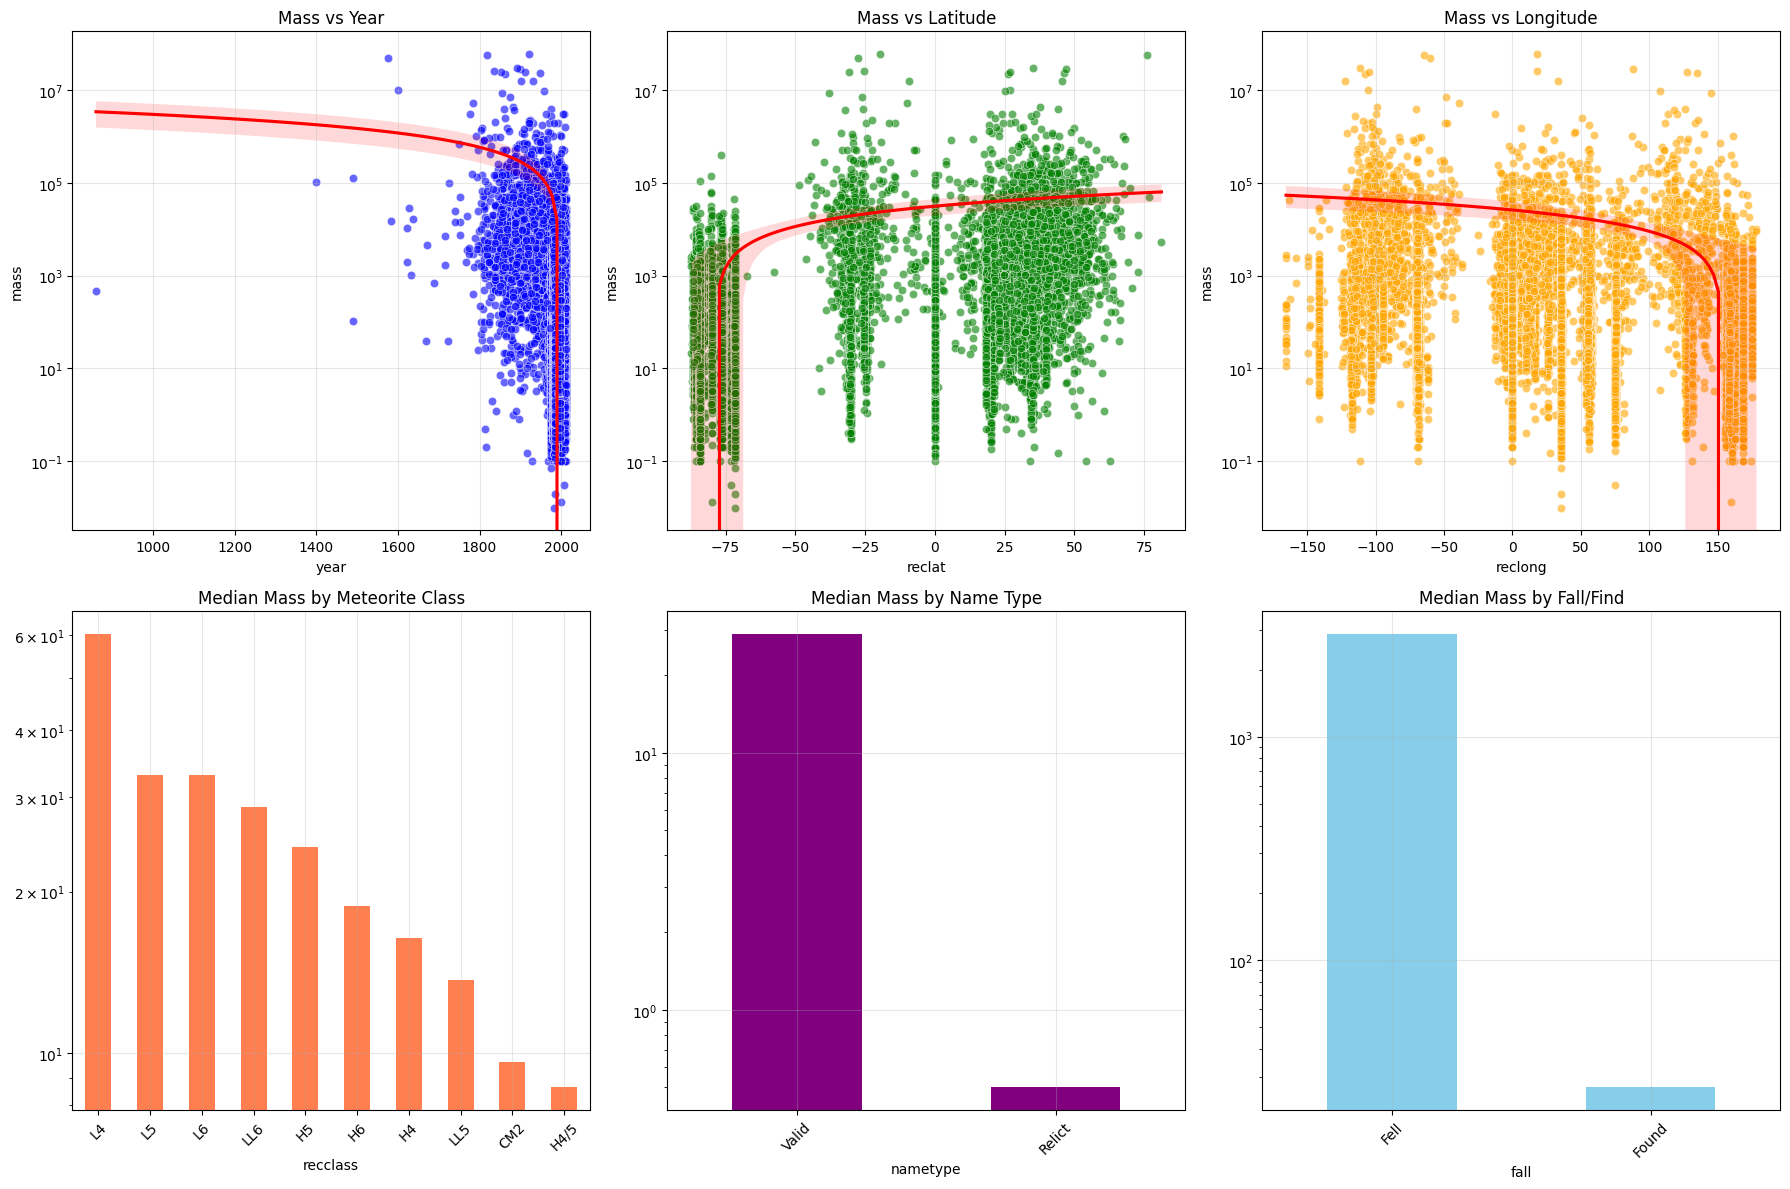

In [6]:
# Mass relationship analysis with different colors
df_clean = df.dropna(subset=['mass']).copy()

# Define plot colors
scatter_colors = ['blue', 'green', 'orange']
bar_colors = ['coral', 'purple', 'skyblue']

# Create figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Scatter plots for numerical variables
sns.scatterplot(data=df_clean, x='year', y='mass', alpha=0.6, color=scatter_colors[0], ax=axes[0,0])
sns.regplot(data=df_clean, x='year', y='mass', scatter=False, color='red', ax=axes[0,0])
axes[0,0].set_yscale('log')
axes[0,0].set_title('Mass vs Year')
axes[0,0].grid(True, alpha=0.3)

sns.scatterplot(data=df_clean, x='reclat', y='mass', alpha=0.6, color=scatter_colors[1], ax=axes[0,1])
sns.regplot(data=df_clean, x='reclat', y='mass', scatter=False, color='red', ax=axes[0,1])
axes[0,1].set_yscale('log')
axes[0,1].set_title('Mass vs Latitude')
axes[0,1].grid(True, alpha=0.3)

sns.scatterplot(data=df_clean, x='reclong', y='mass', alpha=0.6, color=scatter_colors[2], ax=axes[0,2])
sns.regplot(data=df_clean, x='reclong', y='mass', scatter=False, color='red', ax=axes[0,2])
axes[0,2].set_yscale('log')
axes[0,2].set_title('Mass vs Longitude')
axes[0,2].grid(True, alpha=0.3)

# Bar plots for categorical variables
# Top 10 meteorite classes
top_classes = df_clean['recclass'].value_counts().head(10).index
class_data = df_clean[df_clean['recclass'].isin(top_classes)]
class_medians = class_data.groupby('recclass')['mass'].median().sort_values(ascending=False)
class_medians.plot(kind='bar', ax=axes[1,0], color=bar_colors[0])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Median Mass by Meteorite Class')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(True, alpha=0.3)

# Name type
nametype_medians = df_clean.groupby('nametype')['mass'].median().sort_values(ascending=False)
nametype_medians.plot(kind='bar', ax=axes[1,1], color=bar_colors[1])
axes[1,1].set_yscale('log')
axes[1,1].set_title('Median Mass by Name Type')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(True, alpha=0.3)

# Fall vs Find
fall_medians = df_clean.groupby('fall')['mass'].median().sort_values(ascending=False)
fall_medians.plot(kind='bar', ax=axes[1,2], color=bar_colors[2])
axes[1,2].set_yscale('log')
axes[1,2].set_title('Median Mass by Fall/Find')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
fig.savefig("./images/mass_pre_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

In [7]:
df_corr = df_clean[['mass', 'year', 'reclat', 'reclong']].copy()

# Calculate correlations with mass
correlations = df_corr.corr()['mass'].drop('mass')
print("Correlation coefficients with Mass:")
for var, corr in correlations.items():
    print(f"  {var}: {corr:.4f}")

Correlation coefficients with Mass:
  year: -0.1219
  reclat: 0.0293
  reclong: -0.0219


### 3.3 Missing Value Imputation Strategy

**Hierarchical Imputation Approach for Mass Values:**

* Intuitively we can classify recclass as having a relationship with mass since class is determined by meteorite composition.
* From the above analysis it can be found out that year has a weak negative correlation with mass that is higher than other variables
* Therefore, the medians of mass vales grouped by these two variables will be used to impute the missing values.

In [8]:
recclass_medians = df.groupby('recclass')['mass'].median()
mapped_medians = df['recclass'].map(recclass_medians)
df['mass'] = df['mass'].fillna(mapped_medians)

year_medians = df.groupby('year')['mass'].median()
mapped_medians = df['recclass'].map(recclass_medians)
df['mass'] = df['mass'].fillna(mapped_medians)

overall_median = df['mass'].median()
df['mass'] = df['mass'].fillna(overall_median)

df.to_csv('./data/cleaned_meteorite_data.csv', index=False)

## 4. Exploratory Data Analysis

### 4.1 Main Variables Distribution Analysis

1. **Mass Distribution**: Shows a highly right-skewed distribution with most meteorites having relatively small masses. The majority of meteorites fall under 100g, with a long tail extending to much larger specimens.

2. **Year Distribution**: Reveals interesting temporal patterns:
   - Extremely high rate in observations/discoveries after 1974
   - lower rate from the range 1753 to 1973
   - Single observations very rarely in years below 1752

3. **Recclass (Meteorite Class)**: 
   - Dominated by ordinary chondrites (L6, H5, L5, etc.)
   - Shows the diversity of meteorite types with some classes being much rarer
   - Top 20 classes displayed due to high diversity (>450 unique classes)

4. **Nametype**: Predominantly "Valid" meteorites, indicating most entries are confirmed meteorite finds rather than potential or relict specimens

5. **Fall vs Find**: Significantly more "Found" meteorites than "Fell" meteorites, reflecting the difficulty of witnessing actual meteorite falls versus discovering them later

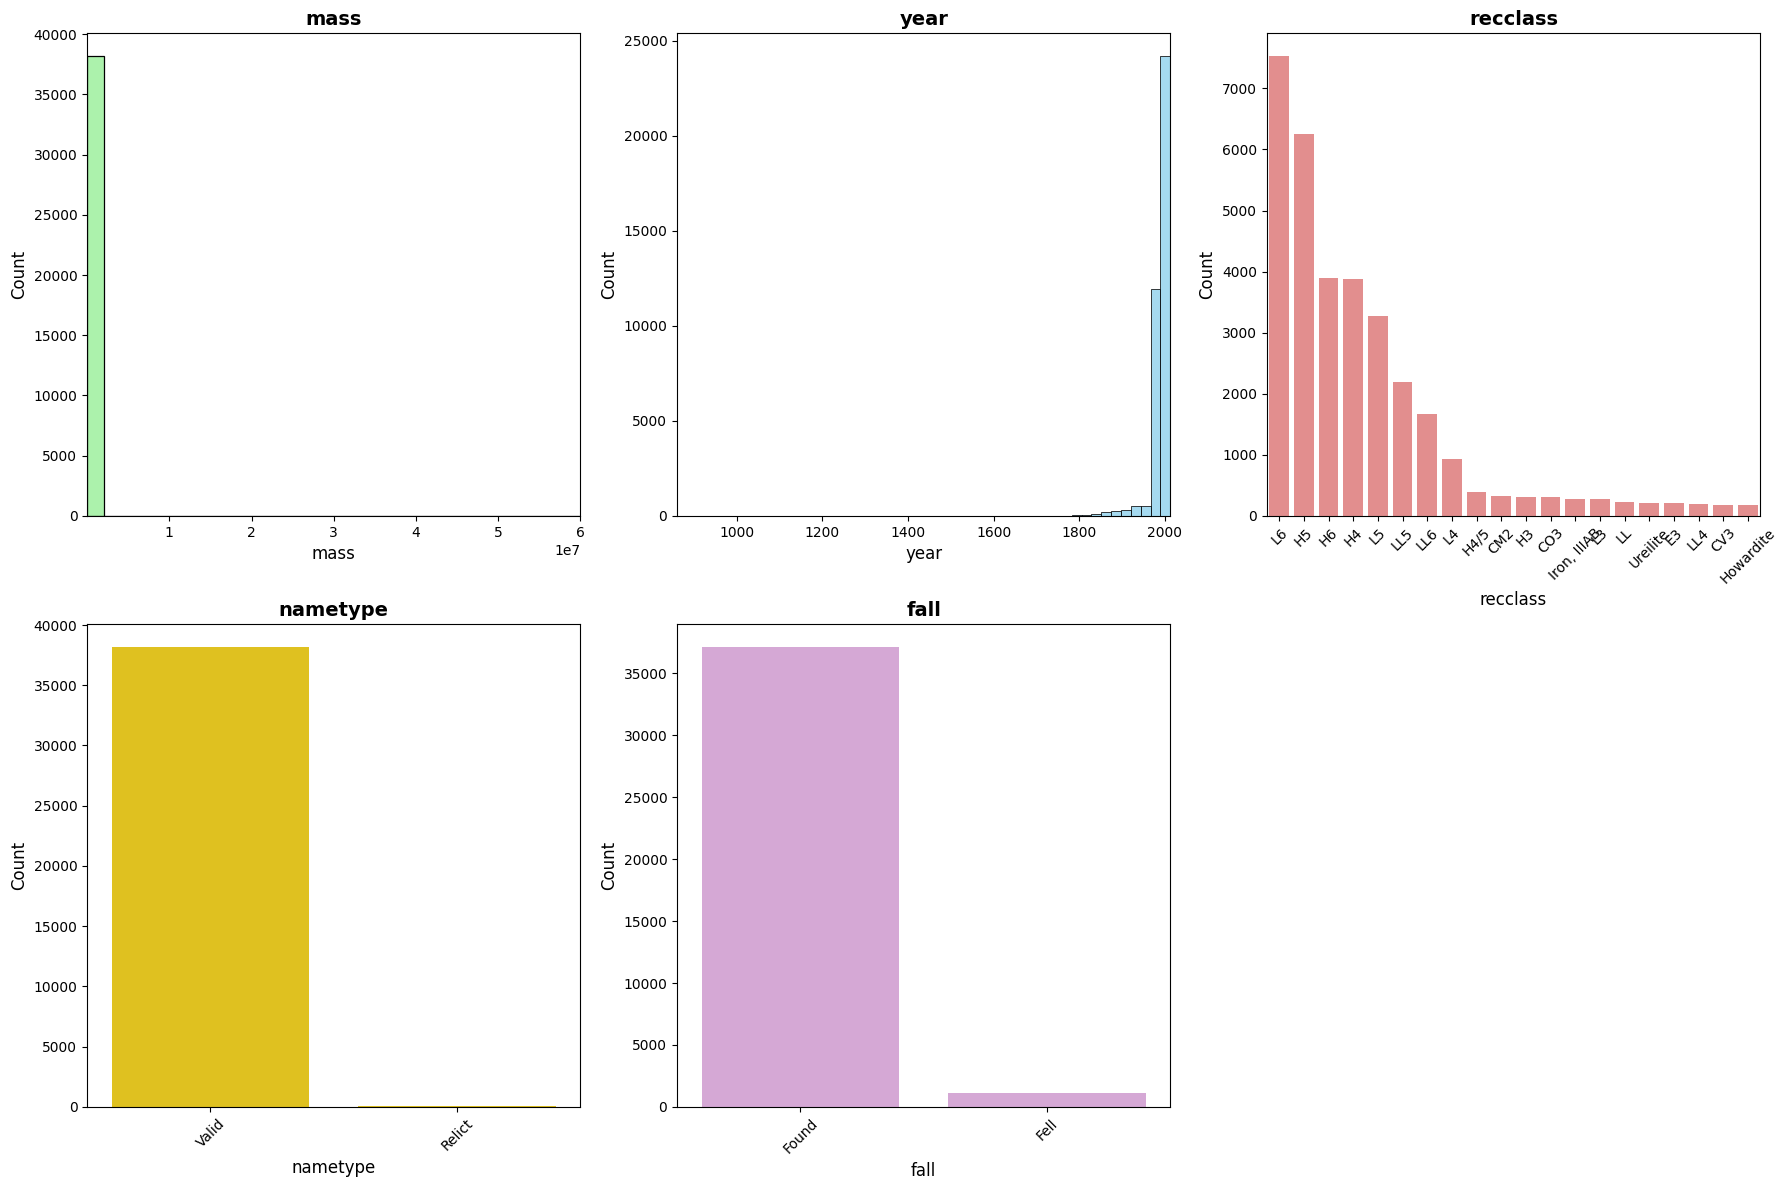

In [9]:
# Main Variables Visualization
columns_main = ['mass', 'year', 'recclass', 'nametype', 'fall']
colors_main = ['lightgreen', 'skyblue', 'lightcoral', 'gold', 'plum']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(columns_main):
    ax = axes[i]
    
    if pd.api.types.is_numeric_dtype(df[col]):
        # Numeric columns: histogram
        bins = 50 if col == 'year' else 30
        sns.histplot(df[col], bins=bins, kde=False, ax=ax, color=colors_main[i])
        ax.set_xlim(df[col].min(), df[col].max())
    else:
        # Categorical columns: count plot
        sns.countplot(x=df[col], order=df[col].value_counts().index[:20], 
                     ax=ax, color=colors_main[i])
        ax.tick_params(axis='x', rotation=45)
    
    ax.set_title(col, fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Hide the last empty subplot
axes[-1].set_visible(False)

plt.tight_layout()
fig.savefig("./images/main_visualization.png", dpi=300, bbox_inches="tight")
plt.show()


### 4.2 Detailed Mass Distribution Analysis

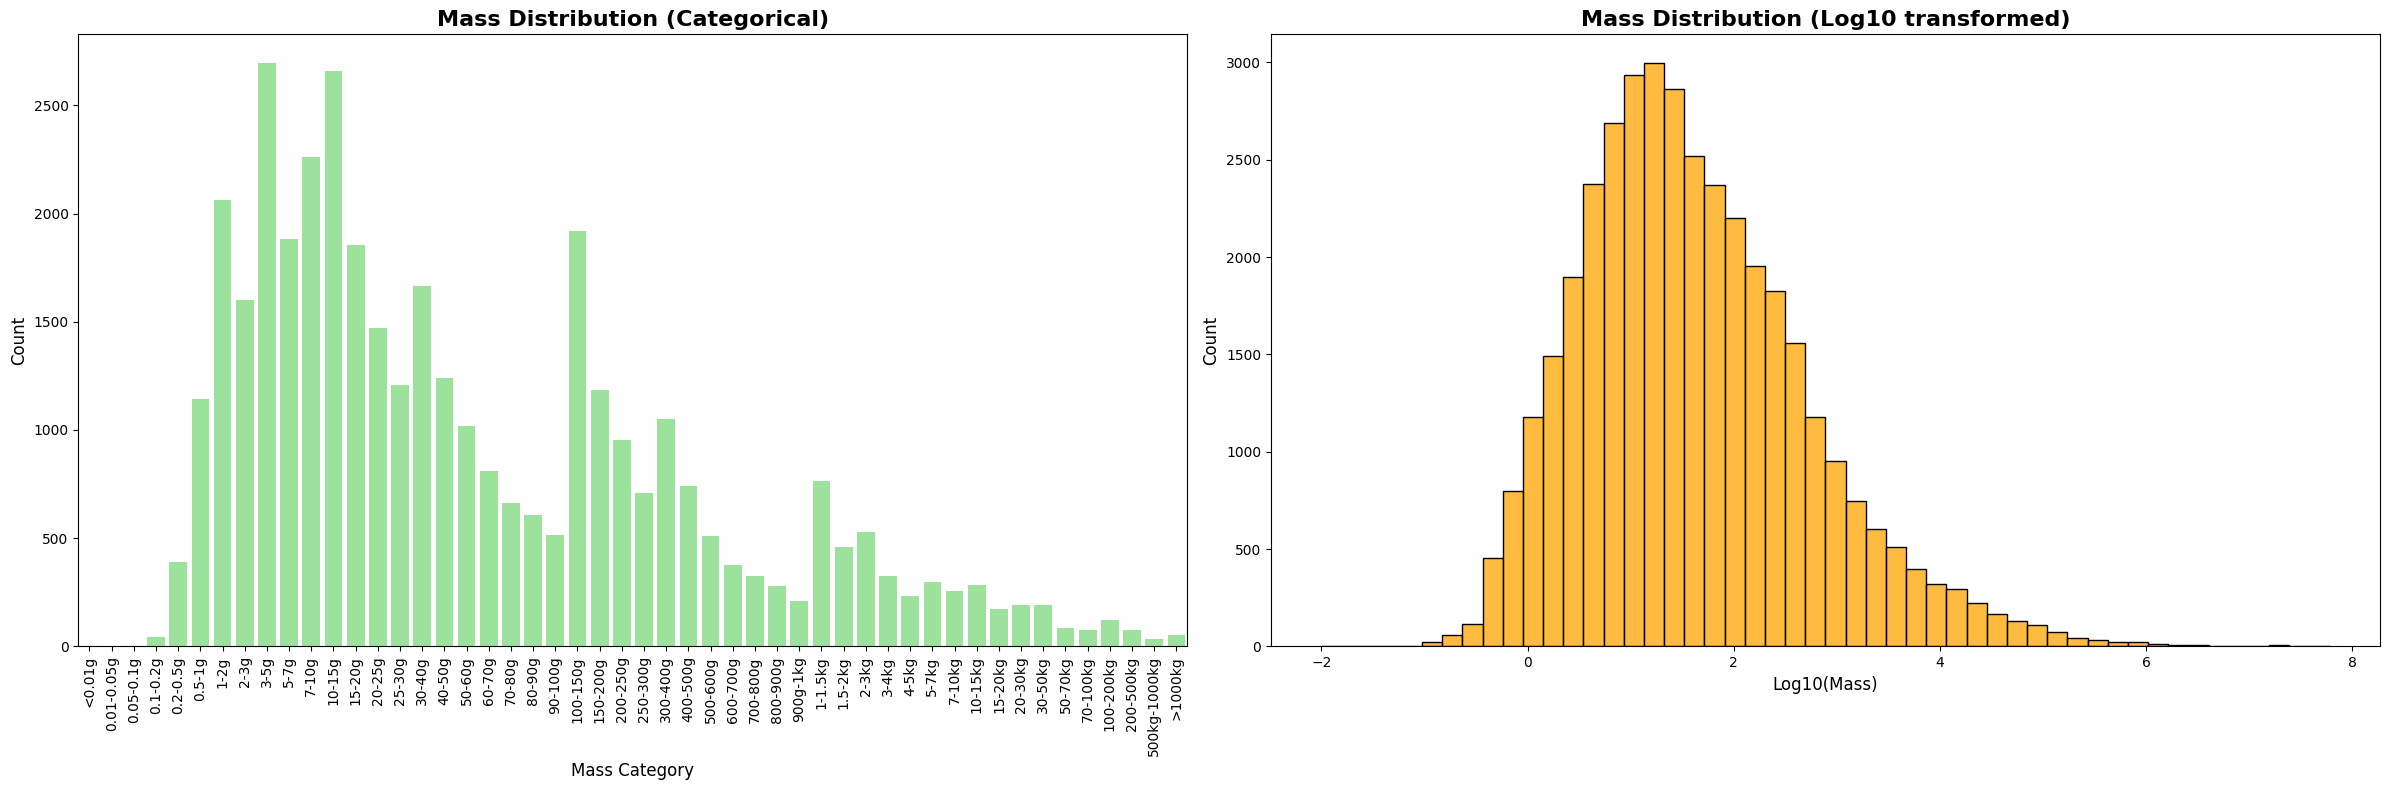

In [10]:
mass_plot_df = df.copy()

# Detailed Mass Distribution (already binned)
mass_bins = [0, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100, 
             150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 3000, 4000, 5000, 7000, 10000, 
             15000, 20000, 30000, 50000, 70000, 100000, 200000, 500000, 1000000, float('inf')]

mass_labels = ['<0.01g', '0.01-0.05g', '0.05-0.1g', '0.1-0.2g', '0.2-0.5g', '0.5-1g', '1-2g', '2-3g', '3-5g', 
               '5-7g', '7-10g', '10-15g', '15-20g', '20-25g', '25-30g', '30-40g', '40-50g', '50-60g', '60-70g', 
               '70-80g', '80-90g', '90-100g', '100-150g', '150-200g', '200-250g', '250-300g', '300-400g', 
               '400-500g', '500-600g', '600-700g', '700-800g', '800-900g', '900g-1kg', '1-1.5kg', '1.5-2kg', 
               '2-3kg', '3-4kg', '4-5kg', '5-7kg', '7-10kg', '10-15kg', '15-20kg', '20-30kg', '30-50kg', 
               '50-70kg', '70-100kg', '100-200kg', '200-500kg', '500kg-1000kg', '>1000kg']

mass_plot_df['mass_category'] = pd.cut(mass_plot_df['mass'], bins=mass_bins, labels=mass_labels, right=False)

# Log transform the original mass (add small epsilon to avoid log(0))
mass_plot_df['log_mass'] = np.log10(mass_plot_df['mass'] + 1e-6)
df['log_mass'] = mass_plot_df['log_mass']

# Create 2-subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

# ---- Left: Detailed mass distribution
sns.countplot(x=mass_plot_df['mass_category'], ax=axes[0], color='lightgreen', order=mass_labels)
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Mass Distribution (Categorical)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Mass Category', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# ---- Right: Log-transformed mass distribution
sns.histplot(mass_plot_df['log_mass'], bins=50, ax=axes[1], color='orange', kde=False)
axes[1].set_title('Mass Distribution (Log10 transformed)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Log10(Mass)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)

plt.tight_layout()
fig.savefig("./images/mass_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

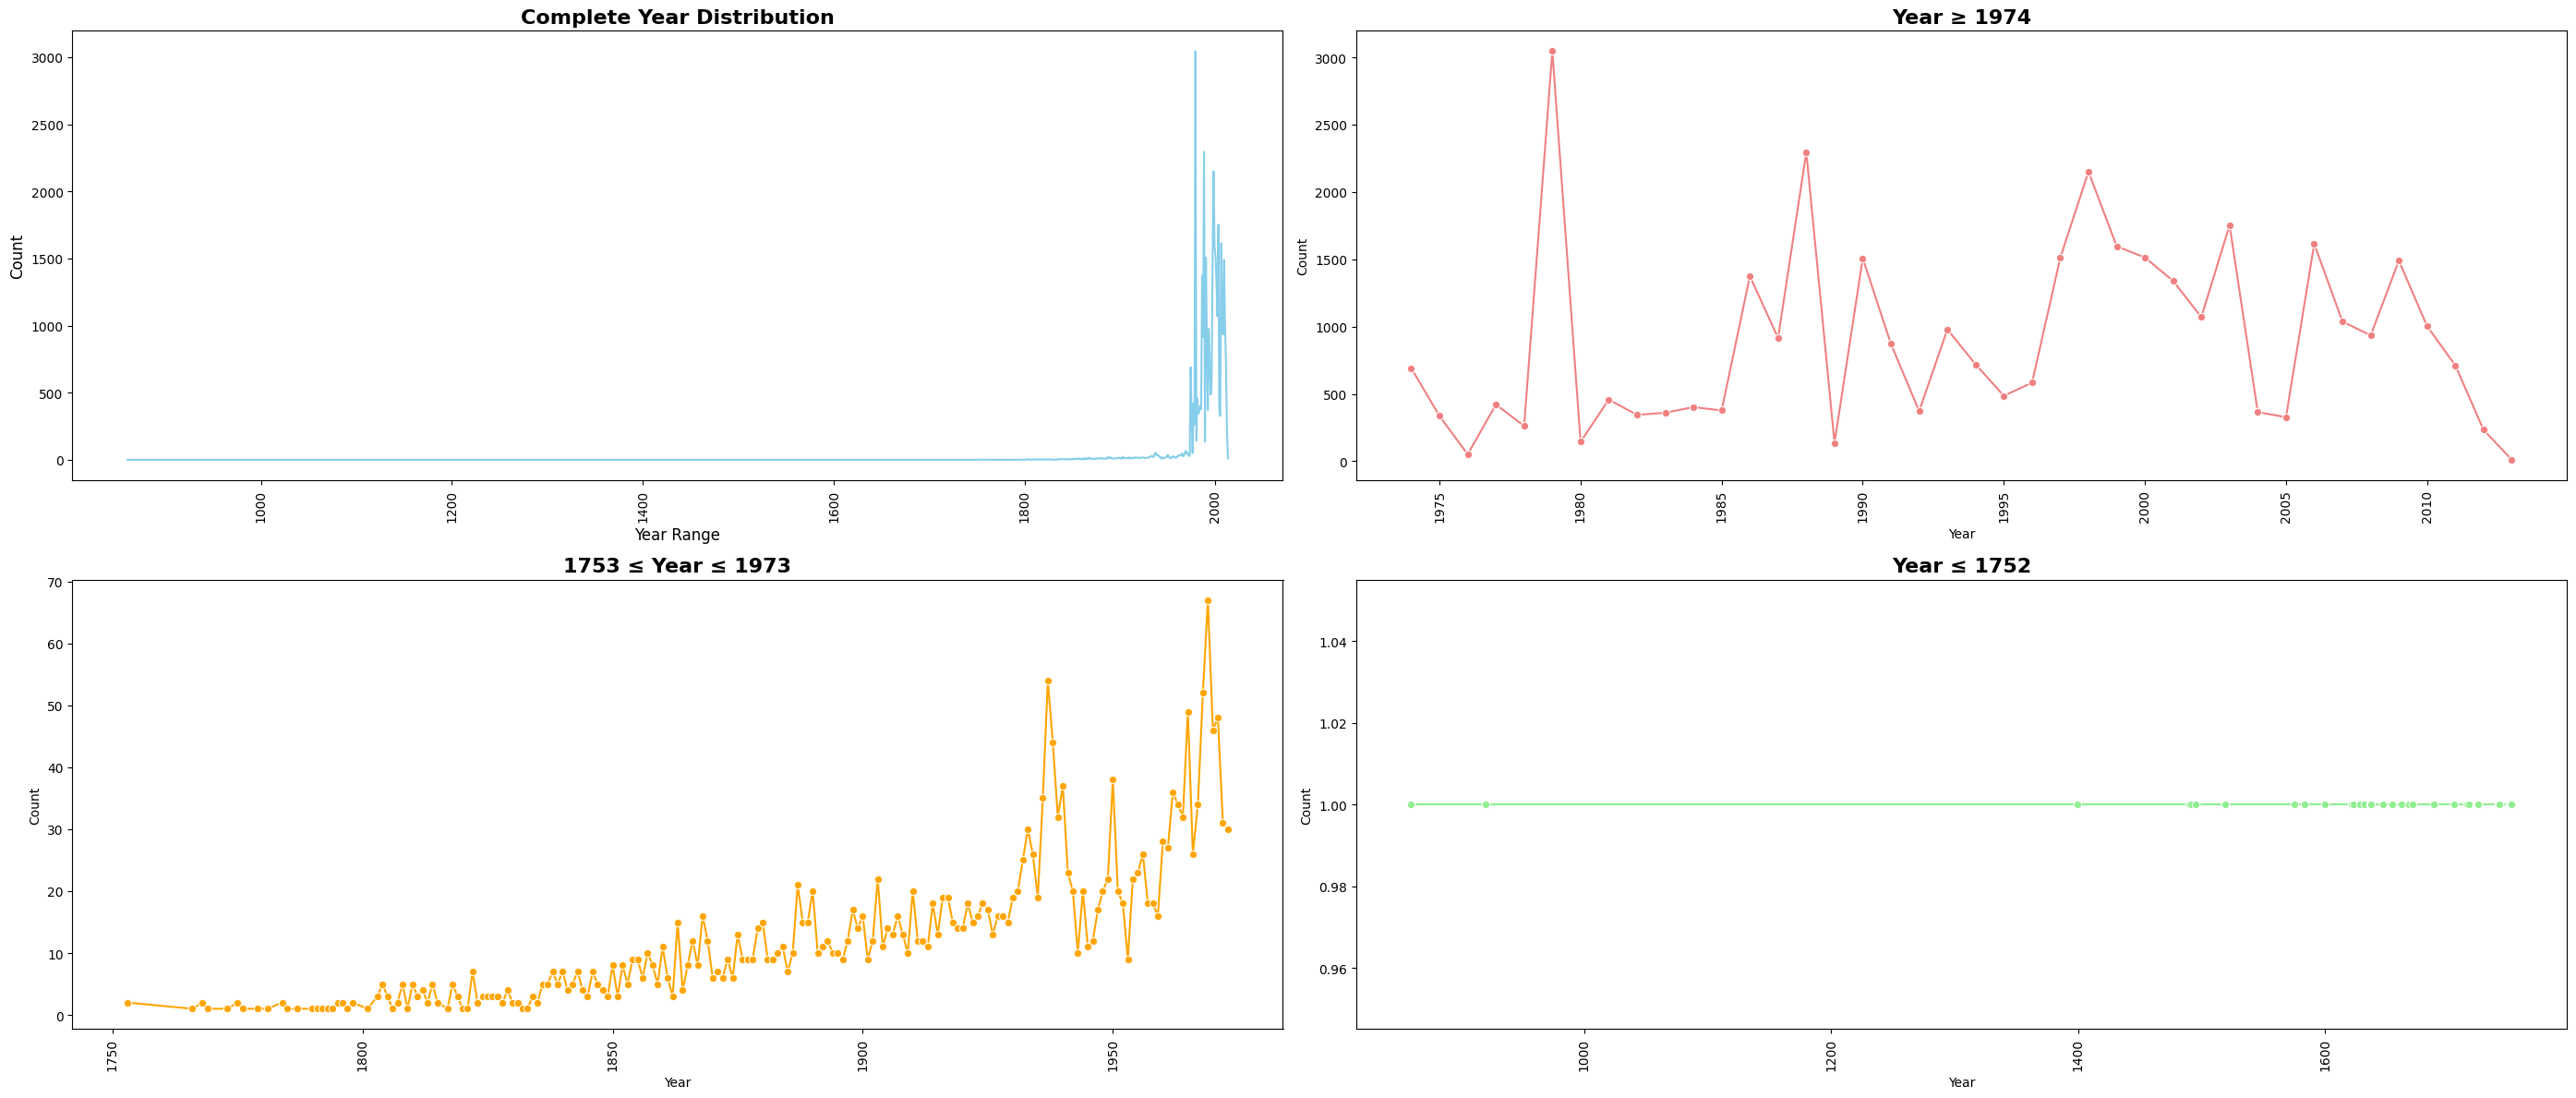

In [11]:
# Split into 3 ranges for line plots
df1 = df[df['year'] >= 1974].reset_index(drop=True)
df2 = df[(df['year'] > 1752) & (df['year'] < 1974)].reset_index(drop=True)
df3 = df[df['year'] <= 1752].reset_index(drop=True)

# Count occurrences per year
counts = df['year'].value_counts().sort_index()
counts1 = df1['year'].value_counts().sort_index()
counts2 = df2['year'].value_counts().sort_index()
counts3 = df3['year'].value_counts().sort_index()

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(28, 12))
axes = axes.flatten()  # flatten so we can index easily

# ---- Top-left: binned year plot
sns.lineplot(x=counts.index, y=counts.values, color='skyblue', ax=axes[0])
axes[0].tick_params(axis='x', rotation=90)
axes[0].set_title('Complete Year Distribution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Year Range', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# ---- Top-right: df1 (> 1994)
sns.lineplot(x=counts1.index, y=counts1.values, ax=axes[1], color="lightcoral", marker="o")
axes[1].set_title("Year ≥ 1974", fontsize=16, fontweight="bold")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis="x", rotation=90)

# ---- Bottom-left: df2 (1753–1994)
sns.lineplot(x=counts2.index, y=counts2.values, ax=axes[2], color="orange", marker="o")
axes[2].set_title("1753 ≤ Year ≤ 1973", fontsize=16, fontweight="bold")
axes[2].set_xlabel("Year")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis="x", rotation=90)

# ---- Bottom-right: df3 (≤ 1752)
sns.lineplot(x=counts3.index, y=counts3.values, ax=axes[3], color="lightgreen", marker="o")
axes[3].set_title("Year ≤ 1752", fontsize=16, fontweight="bold")
axes[3].set_xlabel("Year")
axes[3].set_ylabel("Count")
axes[3].tick_params(axis="x", rotation=90)

plt.tight_layout()
fig.savefig("./images/time_visualization.png", dpi=300, bbox_inches="tight")
plt.show()

### 4.3 Outlier Detection

These outliers represent genuine scientific phenomena rather than data quality issues, so they should be retained for analysis. Large meteorites and rare classifications are scientifically important and removing them would bias the dataset.

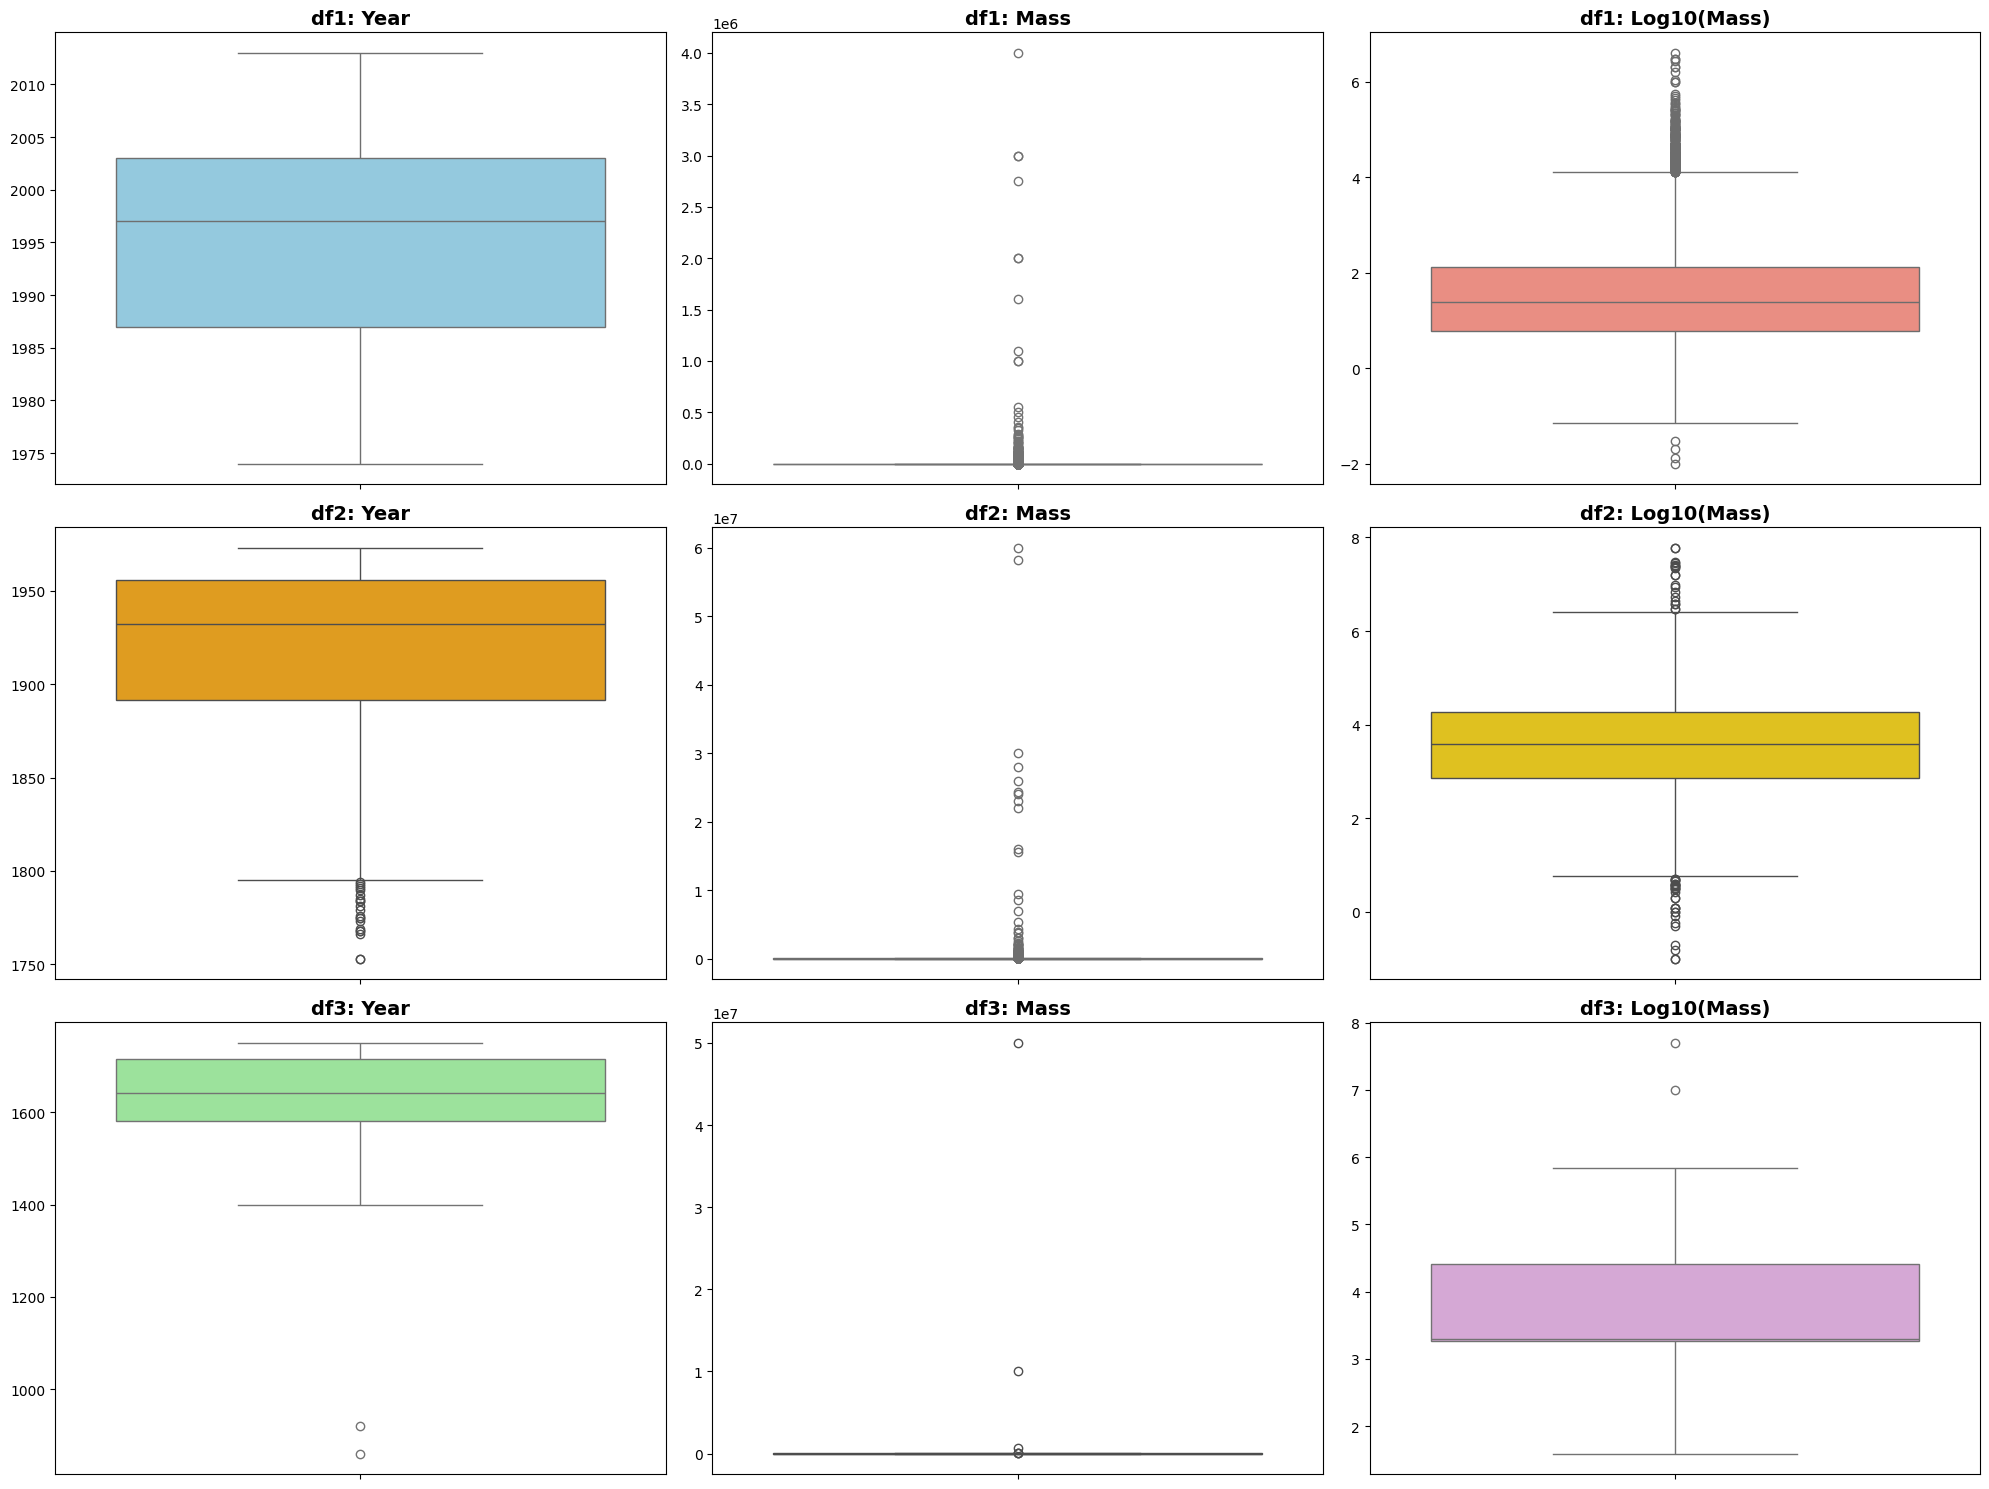

In [12]:
# Define colors for the 9 plots
colors = [
    'skyblue', 'lightgreen', 'salmon',      # row 1: df1
    'orange', 'violet', 'gold',             # row 2: df2
    'lightgreen', 'cyan', 'plum'            # row 3: df3
]

# Prepare figure
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

dataframes = [df1, df2, df3]
df_labels = ['df1', 'df2', 'df3']
variables = ['year', 'mass', 'log_mass']
var_labels = ['Year', 'Mass', 'Log10(Mass)']

# Plotting
for i, df_curr in enumerate(dataframes):
    for j, var in enumerate(variables):
        ax_idx = i*3 + j
        sns.boxplot(y=df_curr[var], ax=axes[ax_idx], color=colors[ax_idx])
        axes[ax_idx].set_title(f'{df_labels[i]}: {var_labels[j]}', fontsize=14, fontweight='bold')
        axes[ax_idx].set_ylabel('')
        axes[ax_idx].set_xlabel('')

plt.tight_layout()
fig.savefig("./images/boxplots.png", dpi=300, bbox_inches="tight")
plt.show()

### 4.4 Handling outliers

Since outliers cannot be removed, a new column is created to identify whether the value is an outlier or not (only the extreme skewed values are considered so there is still skewness)

In [13]:
outlier_threshold = 6.0

for df in [df1, df2, df3]:
    is_outlier = df['log_mass'] > outlier_threshold
    df['is_outlier'] = np.where(is_outlier, 1, 0)
    print(df.head())

               name   id nametype       recclass     mass  fall    year  \
0          Acapulco   10    Valid    Acapulcoite   1914.0  Fell  1976.0   
1  Aioun el Atrouss  423    Valid   Diogenite-pm   1000.0  Fell  1974.0   
2           Akyumak  433    Valid      Iron, IVA  50000.0  Fell  1981.0   
3         Al Zarnkh  447    Valid            LL5    700.0  Fell  2001.0   
4   Alby sur Chéran  458    Valid  Eucrite-mmict    252.0  Fell  2002.0   

     reclat   reclong  log_mass  is_outlier  
0  16.88333 -99.90000  3.281942           0  
1  16.39806  -9.57028  3.000000           0  
2  39.91667  42.81667  4.698970           0  
3  13.66033  28.96000  2.845098           0  
4  45.82133   6.01533  2.401401           0  
       name   id nametype recclass      mass  fall    year    reclat  \
0    Aachen    1    Valid       L5      21.0  Fell  1880.0  50.77500   
1    Aarhus    2    Valid       H6     720.0  Fell  1951.0  56.18333   
2      Abee    6    Valid      EH4  107000.0  Fell  1952.

### 4.5 Final Observations

* Log transform can be used for the mass variable to approximate values for a smoother chloropleth visualization.
* Year ranges can be split into separate sections based on frequency, and also performance increase in visualization.
* Outliers are present but cannot be removed since they are valid data, therefore a new column is created for extreme outlier visualization in the final dashboard.
* Fixing skewness of the mass variable increases complexity, therefore is not handled.
* Three separate datasets are created with geo coordinates, for 3 separate geo plots based on time period.

## 5. Final dataset sampling

In [14]:
df1.to_csv('./data/geo_data1.csv', index=False)

df1_sample = df1.sample(n=5000, random_state=42)
df1_sample.to_csv('./data/sample1.csv', index=False)

df2.to_csv('./data/geo_data2.csv', index=False)
df3.to_csv('./data/geo_data3.csv', index=False)